# Data Wrangling Template

## Gather

In [12]:
import requests
import pandas as pd

### gather twitter-archive-enhanced.csv file

In [13]:
#read locally stored file
df_twarchive = pd.read_csv('twitter-archive-enhanced.csv')

### gather image-predictions.tsv file

In [14]:
tgt_filename = 'image-predictions.tsv'

In [15]:
#download file from the cloud
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open(tgt_filename, 'wb') as file:
    file.write(r.content)

In [17]:
#read dataframe from file
df_image = pd.read_csv(tgt_filename, sep = '\t')
df_image.tweet_id.count()

2075

### gather tweed_json.txt

Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the **tweet IDs in the WeRateDogs Twitter archive**, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) 
- tweet ID
- retweet count
- favorite count

In [18]:
#refer to twitter application https://apps.twitter.com/app/14714948/keys
#import authorization variables for security reasons
import access.my_secret as xs
import tweepy

auth = tweepy.OAuthHandler(xs.consumer_key, xs.consumer_secret)
auth.set_access_token(xs.access_token, xs.access_secret)
api = tweepy.API(auth)


In [19]:
#extract tweet json from twitter
def get_tweet(tweet_id):
    tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit=True)
    return tweet._json

In [20]:
# for testing
# print(get_tweet(666082916733198337))

In [21]:
#get the timer set up
from timeit import default_timer as timer
import datetime
import json

json_filename = 'tweet_json.txt'

In [22]:
#get tweet
#write json file line by line and log progress
with open(json_filename, 'w') as file, open('log.txt','w') as log:
    for tweet_id in df_twarchive.tweet_id:
        result = ''
        start = timer()
        try:
            content = get_tweet(tweet_id)
            #add newline is helpful to read the file line by line later
            file.write(json.dumps(content) + '\n')
            result = 'ok'
        except tweepy.TweepError:
            result = 'TweepError'
        end = timer()
        log.write(('%s\t%s\t%s\t%s\n') % (str(datetime.datetime.now()), result, str(tweet_id), str(end - start)))
        

In [27]:
#count number of tweets
i = 0
with open(json_filename, 'r') as file:  
    for row in file:
        i += 1
print("row count:", i)

row count: 2345


## Assess

After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. Detect and document at least **eight (8) quality issues and two (2) tidiness issues** in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the **issues that satisfy the Project Motivation must be assessed.**

Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).

### assess twitter-archive-enhanced.csv file

#### quality issues
1. derive clear categories for source(iPhone App, vine.co, Twitter Web Client, TweetDeck)
2. make this source column categorical
3. deal with a few invalid ratings where rating_numerator is 0 or rating_denominator is 0
    - 835246439529840640 rating has been changed to from 960/0 to 13/10 according to current twitter post
    - 835152434251116546 rating has been changed to from 0/10 to 11/10 according to current twitter post
    - 746906459439529985 no rating according to current twitter post -> filter out
4. take out ratings with a rating_denominator other than 10 as these are invalid ratings or rate multiple dogs at once.
5. take out ratings with rating_numerator > 15 they seem to be invalid
6. take out retweeds You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets. (retweeted_status_id is NaN)
7. convert wrong dog names to Null: "a", "the", "an"

#### tidyness issues
1. four columns for the dog_stage can be put into one categorial variable (doggo,floofer,pupper,puppo) and turn the default value "None" into a Null or "unknown"

In [10]:
df_twarchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
df_twarchive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1484,693231807727280129,NaN,NaN,2016-01-30 00:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Bodie. He's not proud of what he did, ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/693231807...,9,10,Bodie,None,None,None,None
1539,689661964914655233,NaN,NaN,2016-01-20 04:13:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Luca. He's a Butternut Scooperfloof. Glor...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689661964...,12,10,Luca,None,None,None,None
1451,695794761660297217,NaN,NaN,2016-02-06 02:22:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wyatt. His throne is modeled after him...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695794761...,13,10,Wyatt,None,None,None,None
1381,700890391244103680,NaN,NaN,2016-02-20 03:51:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chet. He's dapper af. His owners want ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700890391...,11,10,Chet,None,None,None,None
471,816697700272001025,NaN,NaN,2017-01-04 17:27:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Binky. She appears to be rather h*ckin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/816697700...,12,10,Binky,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
33,885984800019947520,NaN,NaN,2017-07-14 22:10:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion advised. This is Jimbo. He w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885984800...,12,10,Jimbo,None,None,None,None
1519,690735892932222976,NaN,NaN,2016-01-23 03:20:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Peaches. She's a Dingleberry Zand...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690735892...,13,10,Peaches,None,None,None,None
970,750117059602808832,NaN,NaN,2016-07-05 00:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Calvin. He just loves America so much....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750117059...,10,10,Calvin,None,None,None,None
901,758474966123810816,NaN,NaN,2016-07-28 01:31:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Brandonald. He accidentally opened the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758474966...,11,10,Brandonald,None,None,None,None


In [29]:
df_twarchive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [35]:
#check the latest tweet
print(df_twarchive.timestamp.min())
print(df_twarchive.timestamp.max())


2015-11-15 22:32:08 +0000
2017-08-01 16:23:56 +0000


In [13]:
df_twarchive.describe()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
 df_twarchive.query('rating_numerator == 0 | rating_denominator == 0')
#835246439529840640 rating has been changed to from 960/0 to 13/10 according to current twitter post
#835152434251116546 rating has been changed to from 0/10 to 11/10 according to current twitter post
#746906459439529985 no rating according to current twitter post -> filter out


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [19]:
df_twarchive[['tweet_id','rating_numerator','rating_denominator']].query('rating_denominator != 10')

,tweet_id,rating_numerator,rating_denominator
313,835246439529840640,960,0
342,832088576586297345,11,15
433,820690176645140481,84,70
516,810984652412424192,24,7
784,775096608509886464,9,11
902,758467244762497024,165,150
1068,740373189193256964,9,11
1120,731156023742988288,204,170
1165,722974582966214656,4,20
1202,716439118184652801,50,50


In [28]:
df = df_twarchive[['tweet_id','rating_numerator','rating_denominator']].query('rating_denominator == 10')
df.rating_numerator.value_counts()
df.query('rating_numerator > 15')

,tweet_id,rating_numerator,rating_denominator
55,881633300179243008,17,10
188,855862651834028034,420,10
189,855860136149123072,666,10
290,838150277551247360,182,10
340,832215909146226688,75,10
695,786709082849828864,75,10
763,778027034220126208,27,10
979,749981277374128128,1776,10
1712,680494726643068929,26,10
2074,670842764863651840,420,10


In [55]:
#check if categories are clean
categories = ['doggo', 'floofer', 'pupper', 'puppo']
for category in categories:
    print(df_twarchive[category].value_counts())
    print()

None     2259
doggo      97
Name: doggo, dtype: int64

None       2346
floofer      10
Name: floofer, dtype: int64

None      2099
pupper     257
Name: pupper, dtype: int64

None     2326
puppo      30
Name: puppo, dtype: int64



In [47]:
df_twarchive.name.value_counts()
#convert to Null: a, the, an

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
Oliver       11
Penny        10
Tucker       10
Lola         10
Winston       9
Bo            9
Sadie         8
the           8
Buddy         7
Toby          7
Bailey        7
an            7
Daisy         7
Rusty         6
Bella         6
Stanley       6
Oscar         6
Jack          6
Scout         6
Leo           6
Jax           6
Dave          6
Milo          6
Koda          6
Gus           5
           ... 
Stormy        1
Kody          1
Harvey        1
Tito          1
Tom           1
Tilly         1
Lolo          1
Binky         1
Hamrick       1
Sully         1
Blu           1
Ike           1
Grizzie       1
Aqua          1
Pherb         1
Keet          1
Aja           1
Lilli         1
Nida          1
Dunkin        1
Grey          1
Ed            1
Mac           1
Halo          1
Clifford      1
Pupcasso      1
Roscoe        1
Lili          1
Tedders       1
Gabby         1
Name: name, Length: 957,

In [58]:
import seaborn as sns
import numpy as np
%matplotlib inline


In [95]:
df_twarchive.query('1 <= rating_numerator <= 15').rating_numerator

0       13
1       13
2       12
3       13
4       12
5       13
6       13
7       13
8       13
9       14
10      13
11      13
12      13
13      12
14      13
15      13
16      12
17      13
18      13
19      13
20      12
21      13
22      14
23      13
24      13
25      12
26      13
27      13
28      13
29      12
        ..
2326     2
2327     7
2328     9
2329    11
2330     6
2331     8
2332    10
2333     9
2334     3
2335     1
2336    11
2337    10
2338     1
2339    11
2340     8
2341     9
2342     6
2343    10
2344     9
2345    10
2346     8
2347     9
2348    10
2349     2
2350    10
2351     5
2352     6
2353     9
2354     7
2355     8
Name: rating_numerator, Length: 2329, dtype: int64

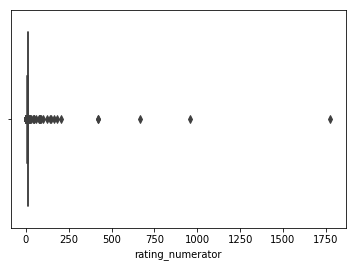

In [112]:
x = df_twarchive.query('1 <= rating_numerator <= 15').rating_numerator
y = df_twarchive.query('1 < rating_denominator < 20').rating_denominator
x = df_twarchive.rating_numerator
y = df_twarchive.rating_denominator
#sns.kdeplot(y, bw=.5, shade=False)
#sns.kdeplot(x, bw=.5, shade=True)
sns.boxplot(x);


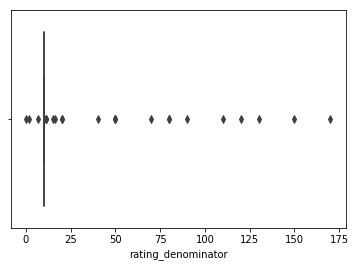

In [113]:
sns.boxplot(y);

In [43]:
#sns.boxplot(x/y);
(x/y).value_counts()

NameError: name 'x' is not defined

In [44]:
sns.regplot(x="rating_numerator", y="rating_denominator",data=df_twarchive);

NameError: name 'sns' is not defined

### assess image-predictions.tsv file

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network.

Example for the data set:
    - tweet_id is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
    - p1 is the algorithm's #1 prediction for the image in the tweet → golden retriever
    - p1_conf is how confident the algorithm is in its #1 prediction → 95%
    - p1_dog is whether or not the #1 prediction is a breed of dog → TRUE
    - p2 is the algorithm's second most likely prediction → Labrador retriever
    - p2_conf is how confident the algorithm is in its #2 prediction → 1%
    - p2_dog is whether or not the #2 prediction is a breed of dog → TRUE
    - etc.

#### quality issues
no quality issues detected

#### tidiyness  issues
2. get the best true dog prediction in one column
3. make the dog prediction categorial

In [36]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [38]:
df_image.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1858,841833993020538882,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,ice_bear,0.336200,False,Samoyed,0.201358,True,Eskimo_dog,0.186789,True
753,688179443353796608,https://pbs.twimg.com/media/CYznjAcUEAQ5Zq7.jpg,1,sorrel,0.811520,False,horse_cart,0.024820,False,Arabian_camel,0.015155,False
506,675898130735476737,https://pbs.twimg.com/media/CWFFt3_XIAArIYK.jpg,1,Labrador_retriever,0.407430,True,malinois,0.077037,True,pug,0.074597,True
1940,860924035999428608,https://pbs.twimg.com/media/C_KVJjDXsAEUCWn.jpg,2,envelope,0.933016,False,oscilloscope,0.012591,False,paper_towel,0.011178,False
772,689557536375177216,https://pbs.twimg.com/media/CZHM60BWIAA4AY4.jpg,1,Eskimo_dog,0.169482,True,Siberian_husky,0.161655,True,dingo,0.154414,False


In [42]:
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


### assess tweet_json.txt
To assess the JSON object I refer to 
- https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object or 
- http://support.gnip.com/sources/twitter/data_format.html with more detail on 
- http://support.gnip.com/doing-more-with-140.html


 tweet ID, retweet count, and favorite count

In [60]:
#read json file line by line
df_list=[]
with open(json_filename, 'r') as file:  
    for row in file:
        data = json.loads(row)
        df_list.append({"tweet_id":data["id"],
                "retweet_count":data["retweet_count"],
                "favorite_count":data["favorite_count"]
               })
#df_tweet = pd.DataFrame.from_dict(df_list)
df_tweet = pd.DataFrame(df_list, columns=["tweet_id", "retweet_count", "favorite_count"])

In [181]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2347 entries, 0 to 2346
Data columns (total 3 columns):
tweet_id          2347 non-null int64
retweet_count     2347 non-null int64
favorite_count    2347 non-null int64
dtypes: int64(3)
memory usage: 55.1 KB


In [176]:
df_tweet.describe()

,tweet_id,retweet_count,favorite_count
count,2.347000e+03,2347.000000,2347.000000
mean,7.424023e+17,3077.365147,8115.849595
std,6.838829e+16,5103.746017,12182.397844
min,6.660209e+17,0.000000,0.000000
25%,6.783846e+17,614.000000,1412.000000
50%,7.189719e+17,1437.000000,3575.000000
75%,7.988157e+17,3585.000000,10069.500000
max,8.924206e+17,78465.000000,142002.000000


In [182]:
df_tweet.favorite_count.value_counts()
df_tweet.retweet_count.value_counts()

611      5
309      5
2935     4
226      4
516      4
95       4
259      4
602      4
131      4
570      4
1200     4
640      4
696      4
140      4
828      4
569      4
399      4
2139     4
3597     4
1193     4
61       3
1147     3
751      3
3265     3
436      3
394      3
705      3
2239     3
691      3
868      3
        ..
2452     1
415      1
417      1
421      1
425      1
6572     1
2424     1
2418     1
293      1
367      1
295      1
4395     1
301      1
4405     1
10195    1
313      1
4411     1
4413     1
4423     1
329      1
333      1
341      1
351      1
2400     1
4451     1
2404     1
361      1
365      1
2414     1
0        1
Name: retweet_count, Length: 1753, dtype: int64

In [185]:
df_tweet[df_tweet.retweet_count>70000]

,tweet_id,retweet_count,favorite_count
1030,744234799360020481,78465,129655


In [187]:
df_twarchive[df_twarchive.tweet_id == 744234799360020481]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1039,744234799360020481,NaN,NaN,2016-06-18 18:26:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744234799...,13,10,None,doggo,None,None,None


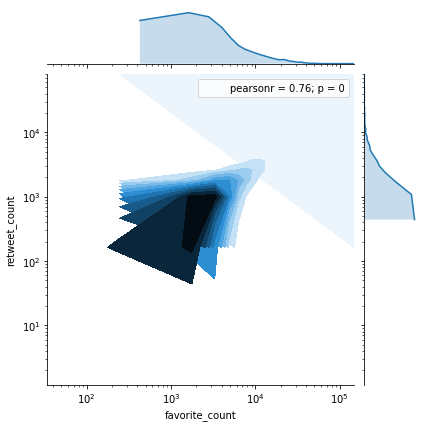

In [69]:
x = df_tweet.favorite_count
y = df_tweet.retweet_count
g = sns.jointplot(x=x, y=y, kind='kde')
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
#g.ax_marg_x.set_xscale('log')
#g.ax_marg_y.set_yscale('log')

In [112]:
df = df_tweet.query('favorite_count > 0 & retweet_count > 0')
df.head(3)
np.log10(4)
x=np.log10(df.favorite_count)
y=np.log10(df.retweet_count)
x=df.favorite_count
y=df.retweet_count

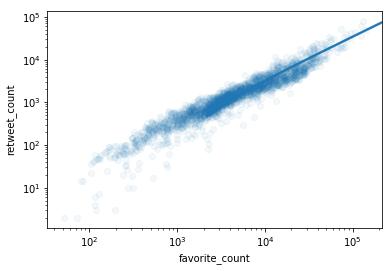

In [132]:
import matplotlib.pyplot as plt

# Initialize figure and ax
fig, ax = plt.subplots()

# Set the scale of the x-and y-axes
ax.set(xscale="log", yscale="log")
sns.regplot(x=x, y=y, data=df, ax=ax, scatter_kws={'alpha':0.05});

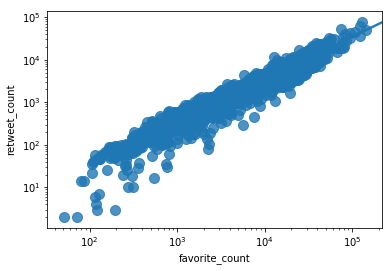

In [121]:

# Initialize figure and ax
fig, ax = plt.subplots()

# Set the scale of the x-and y-axes
ax.set(xscale="log", yscale="log")
sns.regplot(x=x, y=y, data=df, ax=ax, scatter_kws={"s": 100});

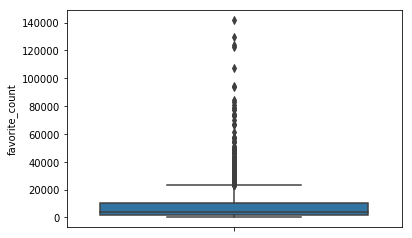

In [64]:
sns.boxplot(y='favorite_count', data=df_tweet)

## Assess new file twitter_archive_master.csv
#### tidyness issues
- merge all three dataset into one
- drop columns in the merged data set which are not required

## Clean

Clean each of the issues you documented while assessing. Perform this cleaning in wrangle_act.ipynb as well. The result should be a high quality and tidy master pandas DataFrame (or DataFrames, if appropriate). Again, **the issues that satisfy the Project Motivation must be cleaned**.

#### Define df_twarchive = pd.read_csv('twitter-archive-enhanced.csv')
#### quality issues

7. convert wrong dog names to Null: "a", "the", "an"

#### tidyness issues
1. four columns for the dog_stage can be put into one categorial variable (doggo,floofer,pupper,puppo) and turn the default value "None" into a Null or "unknown"

In [75]:
#preserve the raw data
dfc_twarchive = df_twarchive.copy()

#### Define
- generate mapping dictionary to map to a short description with clear clear categories iPhone App, vine.co, Twitter Web Client, TweetDeck
- create function to change source
- call function
- change datatype to categorial

#### Code

In [76]:
dfc_twarchive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [77]:
ref_source = {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'iPhone App',
              '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'vine.co', 
              '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client',
              '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'}

def clean_source(tweet):
    if tweet['source'] in ref_source.keys():
        #return clean description
        return ref_source[tweet['source']]
    else:
        return dfc_twarchive.source

dfc_twarchive.source = dfc_twarchive.apply(clean_source, axis=1)

dfc_twarchive.source = dfc_twarchive.source.astype('category')

#### Test

In [78]:
dfc_twarchive.source.value_counts()


iPhone App            2221
vine.co                 91
Twitter Web Client      33
TweetDeck               11
Name: source, dtype: int64

In [79]:
dfc_twarchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null category
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: category(1), float64(4

#### Define
- deal with a few invalid ratings where rating_numerator is 0 or rating_denominator is 0
    - 835246439529840640 rating has been changed to from 960/0 to 13/10 according to current twitter post
    - 835152434251116546 rating has been changed to from 0/10 to 11/10 according to current twitter post
    - 746906459439529985 no rating according to current twitter post -> filter out


#### Code

In [101]:
#update df cell
#see https://stackoverflow.com/questions/12307099/modifying-a-subset-of-rows-in-a-pandas-dataframe/44913631#44913631
dfc_twarchive.loc[dfc_twarchive.tweet_id == 835246439529840640, 'rating_numerator'] = 13
dfc_twarchive.loc[dfc_twarchive.tweet_id == 835246439529840640, 'rating_denominator'] = 10

dfc_twarchive.loc[dfc_twarchive.tweet_id == 835152434251116546, 'rating_numerator'] = 13

dfc_twarchive = dfc_twarchive[dfc_twarchive.tweet_id != 746906459439529985]

NameError: name 'tweet_id' is not defined

#### Test

In [ ]:
dfc_twarchive.loc[dfc_twarchive.tweet_Id.isin([835246439529840640, 835152434251116546, 746906459439529985])]

#### Define
- take out ratings with a rating_denominator other than 10 as these are invalid ratings or rate multiple dogs at once.
- take out ratings with rating_numerator > 15 they seem to be invalid
- take out retweeds You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets. (retweeted_status_id is NaN)


#### Code

In [ ]:
dfc_twarchive = dfc_twarchive[dfc_twarchive.rating_denominator != 10]
dfc_twarchive = dfc_twarchive[dfc_twarchive.rating_numerator > 15]
#https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-certain-columns-is-nan
df.dropna(subset=[1]) 
dfc_twarchive.dropna(subset=['retweeted_status_id'])

#### Test

#### Define

#### Code

#### Test

#### Define

#### Code

#### Test

#### Define

#### Code

#### Test

## Storing, Analyzing, and Visualizing Data for this Project

Store the clean DataFrame(s) in a CSV file with the main one named **twitter_archive_master.csv**. If additional files exist because multiple tables are required for tidiness, name these files appropriately. Additionally, you may **store the cleaned data in a SQLite database** (which is to be submitted as well if you do).

Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least **three (3) insights and one (1) visualization** must be produced.